<h1>Fraud Transaction Detection using Light gradient Bossting </h1>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from catboost import CatBoost, CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('/kaggle/input/fraud-transactions/Fraud.csv')

In [3]:
df['isFraud'].value_counts(normalize=True)

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

So, it is a highly imbalanced dataset. So we will try to downscale the non-fraud transactions for non-biased result and measurements. But first we have to do data cleaning.

# Data Cleaning

In [4]:
#Check for NULL Value
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
#Check for Duplicates
df.duplicated().sum()

0

**As mentioned in the data dictionary there is no data available for transactions to Merchant. So I will simply remove those transactions.**

In [6]:
df=df[~df['nameDest'].str.startswith('M')]

#### I will not remove nameOrig and nameDest column as there are multiple transactions from same account So i will use it but after SCALING

In [7]:
df['nameOrig']=df['nameOrig'].str.replace('C','').astype('int64')
df['nameDest']=df['nameDest'].str.replace('C','').astype('int64')

In [8]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

# Check for outliers

In [9]:
num_columns=['step','amount','oldbalanceOrg', 'newbalanceOrig',
             'oldbalanceDest', 'newbalanceDest']

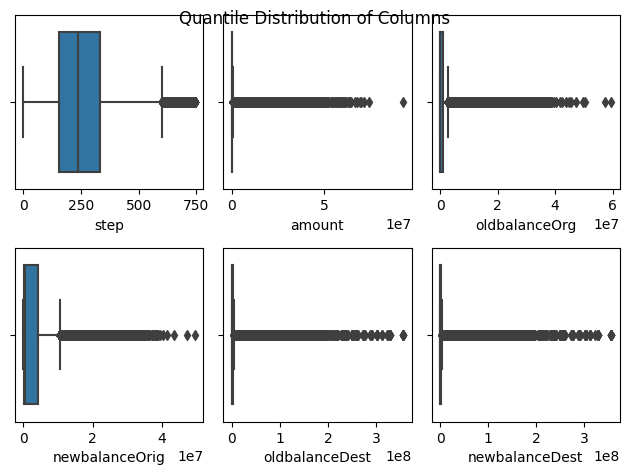

In [10]:
i=1
for col in num_columns:
    plt.subplot(2,3,i)
    sns.boxplot(x=df[df[col]!=0][col],hue=df['isFraud'])
    i=i+1
plt.tight_layout()
plt.suptitle('Quantile Distribution of Columns')
plt.show()

#### well it is clearly visible that most of the columns have very high number of 0 values that results in 0 IQR also, leaving with columns that are constant, hence useless, so in fact I would need to remove the whole column from the data. What a waste!

So i will not be removing outliers and will use Robust Scaler for outlier handling as it will scale the values and also keep the distance between values appropriate

# Model Training and Validation

In [11]:
X=df.drop('isFraud',axis=1)
y=df['isFraud']

In [12]:
# Doing one hot encoding for 'type' column
X=pd.get_dummies(X,columns=['type'],dtype='int')

In [13]:
# I will use NearMiss Undersampling Technique. This will remove the records far from the classification boundary
# The objective is to drop the sample that corresponds to the
# majority and thereby minimalizing the count of the dominating label. 
# This also increases the borderspace between the two labels and thus improving the performance accuracy.
from imblearn.under_sampling import NearMiss
undersample = NearMiss(version=3, n_neighbors=3)
# transform
X, y = undersample.fit_resample(X, y)

In [14]:
y.value_counts()

isFraud
0    8213
1    8213
Name: count, dtype: int64

**So it is finally balanced now. Lets split the data for modelling** 

In [16]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.25,stratify=y)

In [17]:
x_train.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_TRANSFER
11661,306,10000000.00,1577276514,10000000.00,0.0,1370100102,295862.46,10295862.46,0,0,1,0,0
8083,11,274298.12,693428790,0.00,0.0,211013214,897648.33,1271930.80,0,0,0,0,1
14300,552,692743.57,1785747825,692743.57,0.0,1989613920,0.00,0.00,0,0,0,0,1
7639,236,194278.94,961312298,64543.00,0.0,940159993,0.00,194278.94,0,0,1,0,0
15767,686,160088.68,590262415,160088.68,0.0,668046170,301078.64,461167.32,0,0,1,0,0


### Scaling the data

In [18]:
def robust_scale(dff): 
    rs=RobustScaler()
    dff[['amount', 'oldbalanceOrg',
         'oldbalanceDest', 'newbalanceDest']]=rs.fit_transform(dff[['amount', 'oldbalanceOrg',
         'oldbalanceDest', 'newbalanceDest']])
def minmax_scale(dff):
    minmax=MinMaxScaler()
    dff[['step','nameOrig','nameDest','newbalanceOrig']]=minmax.fit_transform(dff[['step','nameOrig','nameDest','newbalanceOrig']])

In [19]:
robust_scale(x_train)
robust_scale(x_test)
minmax_scale(x_train)
minmax_scale(x_test)

How did you select variables to be included in the model?

Variable selection for the model involves identifying relevant features that contribute to the prediction of fraudulent activity. Techniques include:

1. Domain knowledge: Understanding of fraud mechanisms can guide the selection of relevant variables. 
1. Correlation matrix

<Axes: >

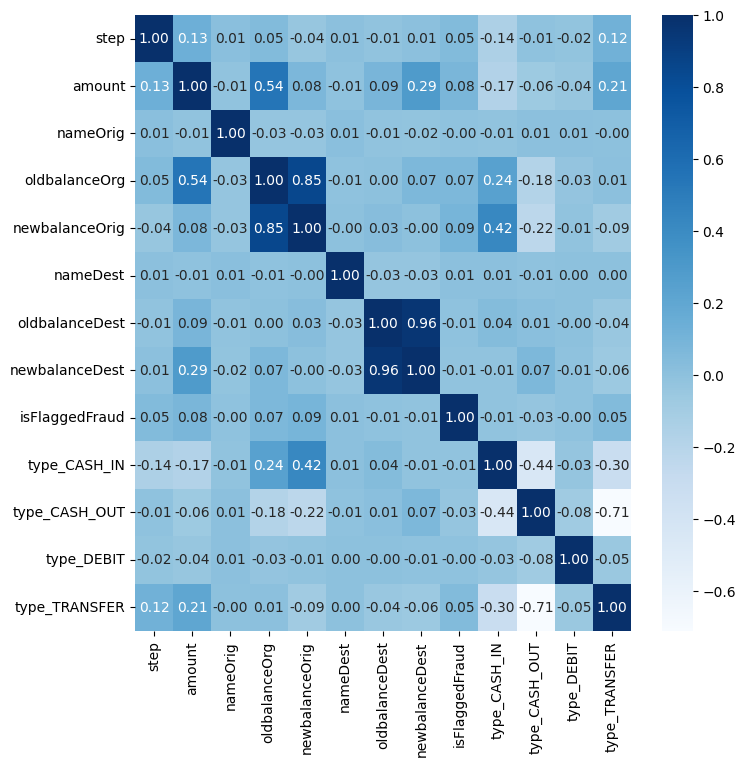

In [26]:
plt.figure(figsize=(8,8))
sns.heatmap(x_train.corr(),annot=True,fmt='.2f',cmap='Blues')

**Well obviously 'amount' will have high correlation with Origin and Dest Amounts and balances. But there is also interesting relationship between "Transfer" transactions and "amount" of trasactions.
Also there is not much features in this dataset to look for relationship but yeah Correlation Matrix is a great tool.**

# Model Building and Testing

### 1. XGB Classifier

In [37]:
xgb=XGBClassifier(
                  booster='gbtree',
                  n_estimators=150,
                  learning_rate=0.1,
                  objective='binary:logistic',
)

In [38]:
xgb.fit(x_train,y_train)
pred=xgb.predict(x_test)
accuracy_score(y_test,pred)

0.9883126369612856

### 2. LGB Classifier

In [39]:
clf = lgb.LGBMClassifier(objective='binary',learning_rate=0.1,
                         feature_fraction=0.8,
                         subsample=0.2
)

In [40]:
clf.fit(x_train,y_train)
pred=clf.predict(x_test)
accuracy_score(y_test,pred)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


0.9905040175310446

### 3. Catboost Classifier

In [35]:
cb_params = {
            'bootstrap_type': 'Bayesian',
            'learning_rate': 0.01,
            'loss_function': 'Logloss',
            'eval_metric': 'Accuracy',
            'random_state': 1,
            'verbose':0
}
cbc=CatBoostClassifier(**cb_params)

In [36]:
cbc.fit(x_train,y_train)
pred=cbc.predict(x_test)
accuracy_score(y_test,pred)

0.9846603360116873

# Voting Classifier

In [41]:
# Training a VotingClassifier with XGB, Catboost and LGB.
# I have given higher weight to LGBoost as it have higher accuracy in claasifying then other models
voting = VotingClassifier(estimators=[
    ('Model1', xgb),
    ('Model2', clf),
    ('Model3', cbc)
], voting='soft', weights = [0.3, 0.5, 0.2])

voting.fit(x_train, y_train)

predictions = voting.predict_proba(x_test)[:, 1]
predict = voting.predict(x_test)

auc_roc = roc_auc_score(y_test, predictions)
acc= accuracy_score(y_test,predict)
print('AUC_ROC_Score: ',auc_roc,'Accuracy: ',acc)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
AUC_ROC_Score:  0.9982019805248548 Accuracy:  0.9905040175310446


## Final Scores

Axes(0.125,0.11;0.62x0.77)
precision: [0.99411187 0.98695022] 
recall: [0.98684851 0.99415774] 
fscore: [0.99046688 0.99054087]


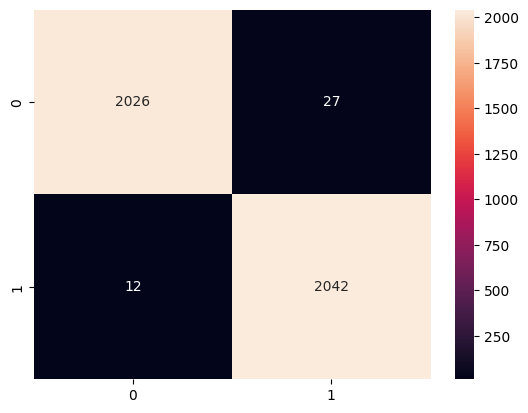

In [42]:
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
cm = confusion_matrix(y_test,predict)
print(sns.heatmap(cm,annot=True,fmt='.0f'))
precision,recall,fscore,_=precision_recall_fscore_support(y_test,predict)
print('precision:',precision,
     '\nrecall:',recall,
     '\nfscore:',fscore)

#### Key Predictive Factors for Fraudulent Customers
Key factors might include:

* Transaction behavior: Unusual patterns compared to the customer's typical transaction history.
* Volume: Sudden spikes in transaction amount.
* Type of Transaction: In most cases Transfer is the root cause of fraud.

#### What kind of prevention should be adopted while company update its infrastructure?
When updating infrastructure, it's important to:

1. Maintain data security: Ensure that data remains encrypted and access is controlled.
1. Test new systems thoroughly: Before full deployment, test for vulnerabilities and ensure the system accurately detects fraud.
1. Update fraud detection models: As new types of fraud emerge, continuously update the models with new data and patterns.

#### Assuming these actions have been implemented, how would you determine if they work?

Continuous Monitoring and Evaluation
* Performance Metrics: Regularly monitor key performance metrics such as precision, recall, F1-score, and ROC-AUC score. An effective model should show high precision (minimizing false positives) and high recall (minimizing false negatives).

* Confusion Matrix Analysis: Review the confusion matrix periodically to understand the model's performance in terms of true positives (correctly identified fraud), false positives (legitimate transactions flagged as fraud), true negatives (correctly identified legitimate transactions), and false negatives (missed fraud cases).

Model Retraining and Updating
* Hyperparameter tuning of models can significatly affect the model performance
* Feature Reevaluation: Continuously evaluate the relevance of features used by the model. Changes in fraudsters' behavior might render some features less predictive and others more critical.

# ! Done